Vesion 1: Predict the direction of price change on next day

### 1. Preparation

In [680]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

import time
import random

In [668]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True

setup_seed(42)

### 2. Data Loading and Preprocessing

In [669]:
def load_from_yf(ticker, period="10y", interval="1d"):
    df: pd.DataFrame = yf.Ticker(ticker).history(period=period, interval=interval)
    return df[["Open", "High", "Low", "Close"]], df[["Volume"]]

In [670]:
def normalized(df):
    return (df - df.mean()) / df.std()

def denormalized(df, value):
    return value * df.std() + df.mean()

In [671]:
price, vol = load_from_yf("TSLA")
print("Data size:", len(vol))

n_price = normalized(np.log(price))
n_vol = normalized(vol)

trainsize = (int) ((len(vol) - 120) * 0.8)
valsize = (int) ((len(vol) - 120) * 0.1)
testsize = (len(vol) - 120) - trainsize - valsize

data = np.concatenate([n_price, n_vol], axis=1)
"""traindata = data[120 : 120+trainsize]
valdata   = data[120+trainsize : 120+trainsize+valsize]
testdata  = data[120+trainsize+valsize :]

print("Train size:", len(traindata))
print("Val size:  ", len(valdata))
print("Test size: ", len(testdata))"""

Data size: 2517


'traindata = data[120 : 120+trainsize]\nvaldata   = data[120+trainsize : 120+trainsize+valsize]\ntestdata  = data[120+trainsize+valsize :]\n\nprint("Train size:", len(traindata))\nprint("Val size:  ", len(valdata))\nprint("Test size: ", len(testdata))'

Data ratio:  {0: 1140, 1: 1257}


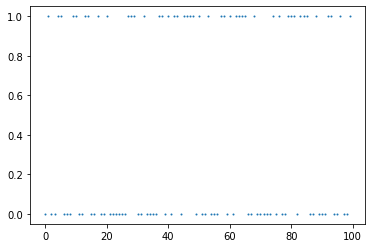

In [672]:
close = price[["Close"]].to_numpy()

change = []
for i in range(len(close)):
    change.append(0 if (i==0) else (close[i]-close[i-1])/close[i-1])
    
label = []
for i in range(len(close)):
    label.append(0 if change[i]<=0 else 1)

trainlabel = label[120 : 120+trainsize]
vallabel   = label[120+trainsize : 120+trainsize+valsize]
testlabel  = label[120+trainsize+valsize : ]

unique, counts = np.unique(label[120:], return_counts=True) 
print("Data ratio: ", dict(zip(unique, counts)))

"""unique, counts = np.unique(trainlabel, return_counts=True) 
print("Train ratio: ", dict(zip(unique, counts)))
unique, counts = np.unique(vallabel, return_counts=True) 
print("Val ratio:   ", dict(zip(unique, counts)))
unique, counts = np.unique(testlabel, return_counts=True) 
print("Test ratio:  ", dict(zip(unique, counts)))"""


plt.scatter(range(100), label[:100], s=1)
plt.show()

### 3. Models & Training

In [688]:
class FCNet(nn.Module): # Doesn't work
    def __init__(self):
        super(FCNet, self).__init__()
        self.fc1 = nn.Linear(in_features=600, out_features=600)
        self.fc2 = nn.Linear(in_features=600, out_features=400)
        self.fc3 = nn.Linear(in_features=400, out_features=20)
        self.fc4 = nn.Linear(in_features=20, out_features=2)

    def forward(self, input):
        input = nn.Flatten()(input)
        x = F.relu(self.fc1(input))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = nn.Softmax()(x)
        return x

FCNet


In [674]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__() # 120
        self.conv1 = nn.Conv1d(in_channels=5, out_channels=30, kernel_size=5) # 116
        self.maxp1 = nn.MaxPool1d(kernel_size=2, stride=2) # 58
        self.conv2 = nn.Conv1d(in_channels=30, out_channels=30, kernel_size=5) # 54
        self.maxp2 = nn.MaxPool1d(kernel_size=2, stride=2) # 27
        self.conv3 = nn.Conv1d(in_channels=30, out_channels=10, kernel_size=5) # 23
        self.flatten = nn.Flatten()
        self.relu1 = nn.ReLU()
        self.fc1 = nn.Linear(in_features=230, out_features=20)
        self.relu2 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=20, out_features=2)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, input):
        x = self.maxp1(self.conv1(input))
        x = self.maxp2(self.conv2(x))
        x = self.flatten(self.conv3(x))
        x = self.fc1(self.relu1(x))
        x = self.fc2(self.relu2(x))
        x = self.softmax(x)
        return x

In [675]:
class AdvLeNet(nn.Module):
    def __init__(self):
        super(AdvLeNet, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=5, out_channels=20, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=20, out_channels=20, kernel_size=5)
        self.conv3 = nn.Conv1d(in_channels=20, out_channels=20, kernel_size=5)
        self.fc1 = nn.Linear(in_features=2240, out_features=100)
        self.fc2 = nn.Linear(in_features=100, out_features=100)
        self.fc3 = nn.Linear(in_features=100, out_features=2)

    def forward(self, input):
        x = F.relu(self.conv1(input))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = nn.Flatten()(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = nn.Sigmoid()(x)
        return x

In [676]:
class ConcatNet(nn.Module):
    def __init__(self):
        super(ConcatNet, self).__init__() # 120
        self.conv1 = nn.Conv1d(in_channels=5, out_channels=30, kernel_size=5) # 116
        self.maxp1 = nn.AvgPool1d(kernel_size=2, stride=2) # 58
        self.conv2 = nn.Conv1d(in_channels=30, out_channels=30, kernel_size=5) # 54
        self.maxp2 = nn.AvgPool1d(kernel_size=2, stride=2) # 27
        self.conv3 = nn.Conv1d(in_channels=30, out_channels=10, kernel_size=5) # 23
        
        self.dconv = nn.Conv1d(in_channels=5, out_channels=10, kernel_size=1) # 20

        self.fc1 = nn.Linear(in_features=450, out_features=100)
        self.fc2 = nn.Linear(in_features=100, out_features=20)
        self.fc3 = nn.Linear(in_features=20, out_features=2)

    def forward(self, input):
        x1 = F.relu(self.maxp1(self.conv1(input)))
        x1 = F.relu(self.maxp2(self.conv2(x1)))
        x1 = nn.Flatten()(F.relu(self.conv3(x1))) # 230

        x2 = nn.Flatten()(F.relu(self.dconv(input[:,:,100:120]))) # 200

        x3 = nn.Flatten()(input[:,3,100:120]) # 20
    
        x = torch.cat((x1, x2, x3), dim=1)
        x = F.relu(F.dropout(self.fc1(x)))
        x = F.relu(self.fc2(x))
        x = nn.Sigmoid()(self.fc3(x))
        return x

**Hyperparameters**

In [677]:
net = ConcatNet()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

epochs = 30

In [678]:
print(summary(net, (5, 120)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 30, 116]             780
         AvgPool1d-2               [-1, 30, 58]               0
            Conv1d-3               [-1, 30, 54]           4,530
         AvgPool1d-4               [-1, 30, 27]               0
            Conv1d-5               [-1, 10, 23]           1,510
            Conv1d-6               [-1, 10, 20]              60
            Linear-7                  [-1, 100]          45,100
            Linear-8                   [-1, 20]           2,020
            Linear-9                    [-1, 2]              42
Total params: 54,042
Trainable params: 54,042
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.21
Estimated Total Size (MB): 0.27
---------------------------------------------

**Training**

In [679]:
trainlosslist, trainacclist = [], []
testlosslist, testacclist = [], []
for epoch in range(epochs):
    epochstart = time.time()

    for i in range(trainsize):
        step_start = time.time()
        optimizer.zero_grad()

        input = torch.tensor([data[i:i+120]]).float().permute(0,2,1)
        target = torch.tensor([label[i+120]])
        output = net(input)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()  

    trainloss = 0
    traincorrect = 0
    with torch.no_grad():
        for i in range(2000):
            input = torch.tensor([data[i:i+120]]).float().permute(0,2,1)
            target = torch.tensor([label[i+120]])
            output = net(input)
            _, predicted = torch.max(output.data, 1)

            trainloss += loss.item()
            traincorrect += (predicted == target).sum().item()
    trainlosslist.append(trainloss)
    trainacclist.append(traincorrect/20)
    
    testloss = 0
    testcorrect = 0
    with torch.no_grad():
        for i in range(trainsize, trainsize+valsize):
            input = torch.tensor([data[i:i+120]]).float().permute(0,2,1)
            target = torch.tensor([label[i+120]])
            output = net(input)
            loss = criterion(output, target)
            _, predicted = torch.max(output.data, 1)

            testloss += loss.item()
            testcorrect += (predicted == target).sum().item()
    testlosslist.append(testloss)
    testacclist.append(testcorrect/3)

    epochtime = time.time() - epochstart
    print(f"Epoch {epoch+1:2d}/{epochs} | Train loss: {(trainloss):7.2f} | Train acc: {(traincorrect/trainsize*100):5.2f}%"
                                      f"| Test avg loss: {(testloss):7.2f} | Test acc: {(testcorrect/valsize*100):5.2f}% | {epochtime:.2f}s")

plt.figure(figsize=(15,3))
plt.title("Train Loss")
plt.plot(trainlosslist, label="train loss")
plt.show()

plt.figure(figsize=(15,3))
plt.title("Test Loss")
plt.plot(testlosslist, label="test loss")
plt.show()

plt.figure(figsize=(15, 3))
plt.title("Accuracy")
plt.plot(trainacclist, label="train acc")
plt.plot(testacclist, label="test acc")
plt.legend(loc="upper right")
plt.show()

Epoch  1/30 | Train loss: 1213.41 | Train acc: 51.60%| Test avg loss:  211.98 | Test acc: 53.67% | 6.24s
Epoch  2/30 | Train loss: 1301.67 | Train acc: 53.00%| Test avg loss:  205.98 | Test acc: 58.33% | 6.82s
Epoch  3/30 | Train loss: 1350.35 | Train acc: 53.00%| Test avg loss:  207.27 | Test acc: 52.00% | 7.56s
Epoch  4/30 | Train loss: 1086.81 | Train acc: 52.00%| Test avg loss:  206.18 | Test acc: 56.00% | 6.48s
Epoch  5/30 | Train loss: 1439.43 | Train acc: 52.45%| Test avg loss:  208.29 | Test acc: 53.67% | 6.32s
Epoch  6/30 | Train loss: 1218.00 | Train acc: 52.25%| Test avg loss:  206.40 | Test acc: 56.00% | 6.63s
Epoch  7/30 | Train loss: 1279.18 | Train acc: 52.10%| Test avg loss:  206.08 | Test acc: 56.00% | 6.14s
Epoch  8/30 | Train loss: 1347.87 | Train acc: 52.10%| Test avg loss:  206.81 | Test acc: 56.00% | 6.42s
Epoch  9/30 | Train loss: 1223.28 | Train acc: 52.05%| Test avg loss:  207.23 | Test acc: 56.00% | 6.39s
Epoch 10/30 | Train loss: 1260.49 | Train acc: 52.50%| 

KeyboardInterrupt: 

### 4. Evaluation

Size: 300
Accuracy: 54.67%



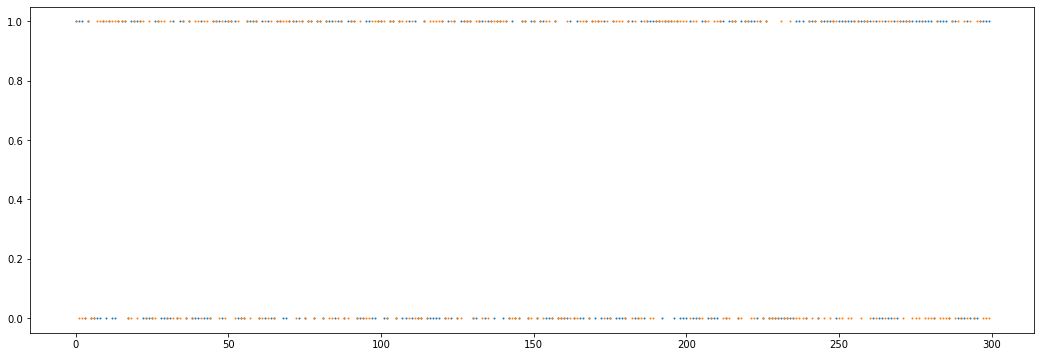

In [ ]:
correct = 0
size = 0
prediction = []
correct_flag = []
with torch.no_grad():
    for i in range(trainsize+valsize, trainsize+valsize+testsize):
        input = torch.tensor([data[i:i+120]]).float().permute(0,2,1)
        target = torch.tensor([label[i+120]])
        output = net(input)
        _, predicted = torch.max(output.data, 1)
        if _.item() > 0:
            prediction.append(predicted.item())
            correct += (predicted == target).sum().item()
            size += 1
            correct_flag.append((predicted == target).sum().item())
        
print(f"Size: {size}")
print(f"Accuracy: {(correct/size*100):.2f}%\n")        

from sklearn.metrics import confusion_matrix
confusion_matrix(label[2120:2120+size], prediction)

plt.figure(figsize=(18,6))
plt.scatter(list(range(size)), correct_flag, s=1)
plt.scatter(list(range(size)), label[2000:2000+size], s=1)
plt.show()

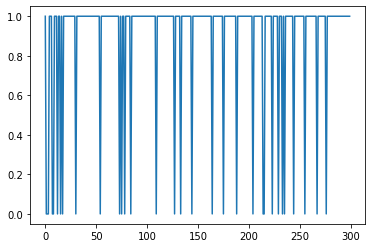

In [ ]:
plt.plot(prediction)
plt.show()